can you adapt it using these parameters for length of stay Table S2: Acute Length of stay parameters
				Percentiles
	Mean	Stdev	Median	5th	95th	25th	75th
Strokes – No ESD	7.4	8.6	4.0	1.0	23.0	2.0	9.0
Strokes – ESD	4.6	4.8	3.0	1.0	11.0	2.0	6.0
Stroke – Mortality	7.0	8.7	4.0	0.5	22.0	2.0	8.0
TIA	1.8	2.3	1.0	0.5	4.0	1.0	2.0
Complex-neurological	4.0	5.0	2.0	0.5	13.6	1.0	5.0
Other	3.8	5.2	2.0	0.5	12.1	1.0	5.0
All distributions modelled as lognormal.


To incorporate the length of stay (LOS) parameters provided in Table S2 and model them using lognormal distributions, we need to adjust the simulation to assign LOS values based on the patient type. Here's the updated code:

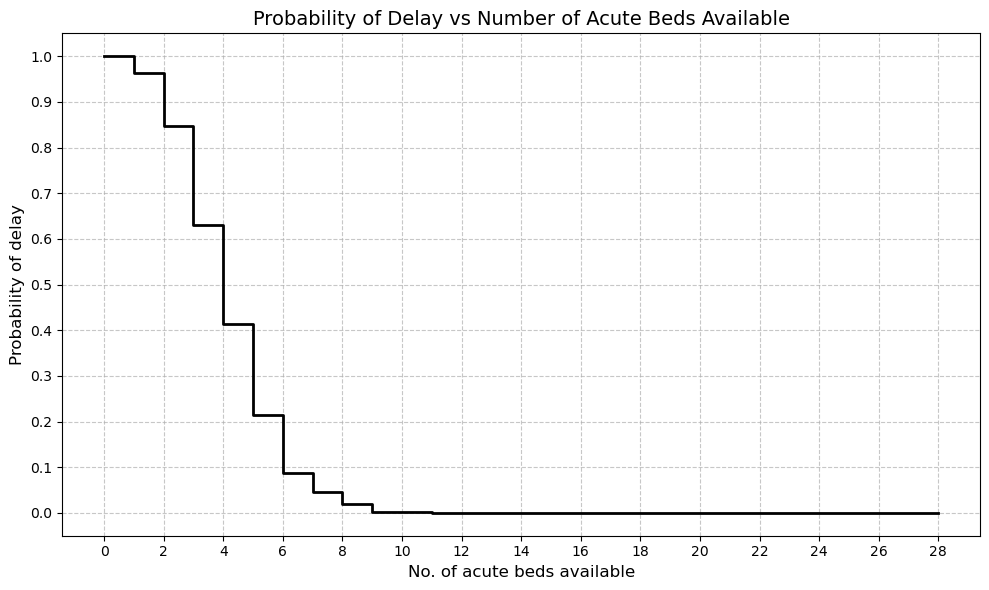

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Configuration for patient types and lognormal LOS parameters
PATIENT_TYPES = {
    "Stroke_No_ESD": {"mean": 7.4, "stdev": 8.6},
    "Stroke_ESD": {"mean": 4.6, "stdev": 4.8},
    "Stroke_Mortality": {"mean": 7.0, "stdev": 8.7},
    "TIA": {"mean": 1.8, "stdev": 2.3},
    "Complex_Neurological": {"mean": 4.0, "stdev": 5.0},
    "Other": {"mean": 3.8, "stdev": 5.2}
}

WARM_UP_DAYS = 365 * 3  # 3 years warm-up
SIMULATION_DAYS = 365 * 5  # Total simulation length (5 years)
RUN_LENGTH_DAYS = SIMULATION_DAYS - WARM_UP_DAYS  # Exclude warm-up period

# Global variables to track occupancy
occupancy_history = []
current_occupancy = 0

def lognormal_los(mean, stdev):
    """Generate a lognormal length of stay given mean and standard deviation."""
    sigma = np.sqrt(np.log(1 + (stdev / mean) ** 2))
    mu = np.log(mean) - (sigma ** 2) / 2
    return np.random.lognormal(mu, sigma)

def patient_generator(env):
    """Generates patients with Poisson arrival times"""
    while True:
        patient_type = random.choice(list(PATIENT_TYPES.keys()))
        los_params = PATIENT_TYPES[patient_type]
        los = lognormal_los(los_params["mean"], los_params["stdev"])
        
        env.process(patient_stay(los))
        interarrival = random.expovariate(1 / sum(1 / v["mean"] for v in PATIENT_TYPES.values()))
        yield env.timeout(interarrival)

def patient_stay(los):
    """Manages patient stay in ASU"""
    global current_occupancy
    current_occupancy += 1
    yield env.timeout(los)
    current_occupancy -= 1

def occupancy_tracker(env):
    """Records daily occupancy"""
    while True:
        occupancy_history.append(current_occupancy)
        yield env.timeout(1)

# Simulation setup
env = simpy.Environment()
env.process(patient_generator(env))
env.process(occupancy_tracker(env))
env.run(until=SIMULATION_DAYS)

# Remove data from the warm-up period
occupancy_history = occupancy_history[WARM_UP_DAYS:]

# Calculate PDF and CDF
max_occ = max(occupancy_history)
counts = np.bincount(occupancy_history, minlength=max_occ + 1)
pdf = counts / len(occupancy_history)
cdf = np.cumsum(pdf)

# Calculate delay probabilities
bed_range = np.arange(0, 29)  # Beds from 0 to 28
delay_probs = []

for n in bed_range:
    if n == 0:
        delay_probs.append(1.0)  # Delay is certain with no beds
    else:
        # P(delay) = P(N ≥ n) = 1 - P(N < n)
        delay_probs.append(1 - cdf[n - 1] if n <= len(cdf) else 0.0)

# Create staggered plot
plt.figure(figsize=(10, 6))
plt.step(bed_range, delay_probs, where="post", linewidth=2, color="black")

# Formatting to match the attached image
plt.title("Probability of Delay vs Number of Acute Beds Available", fontsize=14)
plt.xlabel("No. of acute beds available", fontsize=12)
plt.ylabel("Probability of delay", fontsize=12)
plt.xticks(np.arange(0, 29, step=2), fontsize=10)
plt.yticks(np.arange(0, 1.1, step=0.1), fontsize=10)
plt.grid(axis="both", linestyle="--", alpha=0.7)

# Tight layout for better appearance
plt.tight_layout()
plt.show()
